# Fiche TP4 : Transfer Learning. 

In [39]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import psutil

# Enable mixed precision training
set_global_policy('mixed_float16')
print("Enabled mixed precision training")

# Function to check disk space
def check_disk_space():
    disk = psutil.disk_usage('/')
    print(f"Disk Space: {disk.free / (1024**3):.2f} GB free out of {disk.total / (1024**3):.2f} GB")

# Function to check GPU status
def check_gpu_status():
    print("GPU Status:")
    !nvidia-smi

# Clear GPU memory
def clear_gpu_memory():
    tf.keras.backend.clear_session()
    print("Cleared GPU memory")

# Clear disk space in /kaggle/working
def clear_working_directory():
    !rm -rf /kaggle/working/*
    print("Cleared /kaggle/working directory")

# Check resources and clear disk
clear_working_directory()
check_disk_space()
check_gpu_status()

# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

# Define constants
IMG_SIZE = (128, 128)  # Reduced from 224x224 to save memory
BATCH_SIZE = 16  # Reduced from 32 to avoid memory issues
EPOCHS = 20
LEARNING_RATE = 0.001
DATASET_PATH = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

Enabled mixed precision training
Cleared /kaggle/working directory
Disk Space: 1784.60 GB free out of 8062.39 GB
GPU Status:
Wed Apr 16 20:06:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             30W /  250W |    6417MiB /  16384MiB |      0%      Default |
|              


=== Question 1: Load and Pre-process Dataset ===
Found 29632 images belonging to 4 classes.
Found 12698 images belonging to 4 classes.
Class labels: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


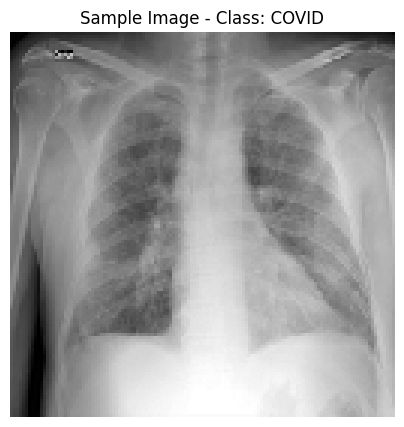

In [ ]:

# 1- Load the  Chest X-rays dataset from 
# https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database 
# and perform pre-processing: data normalization (divide on 255). 
# 2. Stratified Hold-Out Strategy (70% Training, 30% Validation)

print("\n=== Question 1: Load and Pre-process Dataset ===")
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class labels:", train_generator.class_indices)

# Display a sample image
sample_image, sample_label = next(train_generator)
plt.figure(figsize=(5, 5))
plt.imshow(sample_image[0])
plt.title(f"Sample Image - Class: {list(train_generator.class_indices.keys())[np.argmax(sample_label[0])]}")
plt.axis('off')
plt.show()


In [ ]:
# 3- Import one of these architectures with ImageNet pretrained weights: MobileNet, 
# MobileNetV2 (x0.25, x0.5, x0.75, and x1.0), EfficientNet-B0, ShuffleNetV2(x0.5, x0.1, 
# x1.5, and x2.0), ShuffleNetV2b (x0.5, x0.1, x1.5, and x2.0), MnasNet-B, MnasNet-A . 
# 4- Load the pretrained weights from ImageNet (you can use the kerascv library). 

# -----------------------------------
# 3 & 4. Import MobileNet with Pretrained ImageNet Weights
# -----------------------------------
def create_base_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False
    return base_model


=== Question 3 & 4: Import MobileNet ===


In [ ]:
# 5-  Remove and replace the last fully connected layers by three fully connected layers 
# composed of 1024, 512, and c (Number of classes) neurons.  

# -----------------------------------
# 5. Replace Last Fully Connected Layers
# -----------------------------------
def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")


=== Question 5: Replace FC Layers ===
Number of classes: 4


In [ ]:
# 6- Specify the total number of parameters of the new architecture. 
# 7- Print the new architecture (the layers associated to their number of parameters). 

# -----------------------------------
# 6 & 7. Specify Total Parameters and Print Architecture
# -----------------------------------
base_model = create_base_model()
model = create_model(base_model, num_classes)
model.summary()
print(f"Total number of parameters: {model.count_params()}")


=== Question 6 & 7: Parameters and Architecture ===
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast (Cast)                          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,805,316 (18.33 MB)

 Trainable params: 1,576,452 (6.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Total number of parameters: 4805316


In [ ]:
# 8- Retrain the last (two convolutional layers + the last three fully connected), (one 
# convolutional layers + the last three fully connected), and (the last three fully 
# connected) using: the transfer learning strategy for 20 epochs with a batch size of 
# 64 and the Adam optimizer with a learning rate of 0.001. 


# -----------------------------------
# 8. Retrain Layers Using Transfer Learning
# -----------------------------------
print("\n=== Question 8: Retrain Layers ===")
def unfreeze_layers(model, num_conv_layers):
    # Freeze all layers first
    for layer in model.layers:
        layer.trainable = False
    
    # Identify actual convolutional layers (exclude bn and relu)
    conv_layers = [layer for layer in model.layers if layer.name.startswith(('conv_pw_', 'conv_dw_')) and not layer.name.endswith(('_bn', '_relu'))]
    if num_conv_layers > 0:
        selected_layers = conv_layers[-num_conv_layers:]
        print(f"Unfreezing last {num_conv_layers} convolutional layers: {[layer.name for layer in selected_layers]}")
        for layer in selected_layers:
            layer.trainable = True
    
    # Unfreeze dense layers
    for layer in model.layers[-3:]:
        layer.trainable = True

configurations = [
    (2, "Two Conv + FC"),
    (1, "One Conv + FC"),
    (0, "Only FC")
]

history_dict = {}
training_times = {}

for num_conv_layers, config_name in configurations:
    print(f"\nTraining configuration: {config_name}")
    
    # Clear GPU memory and check resources
    clear_gpu_memory()
    check_gpu_status()
    
    # Create fresh model
    base_model = create_base_model()
    model = create_model(base_model, num_classes)
    
    # Unfreeze specified layers
    unfreeze_layers(model, num_conv_layers)
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train model
    start_time = time.time()
    try:
        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=validation_generator,
            verbose=1
        )
    except Exception as e:
        print(f"Training failed for {config_name}: {str(e)}")
        continue
    
    end_time = time.time()
    
    # Store history and training time
    history_dict[config_name] = history.history
    training_times[config_name] = end_time - start_time
    print(f"Training time for {config_name}: {training_times[config_name]:.2f} seconds")
    
    # Save model
    model.save(f"/kaggle/working/model_{config_name.replace(' ', '_')}.h5")


=== Question 8: Retrain Layers ===

Training configuration: Two Conv + FC
Cleared GPU memory
GPU Status:
Wed Apr 16 20:06:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             31W /  250W |    6417MiB /  16384MiB |      0%      Default |
|                                 

E0000 00:00:1744834011.532658     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744834011.731595     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1852/1852 ━━━━━━━━━━━━━━━━━━━━ 121s 62ms/step - accuracy: 0.6318 - loss: 0.9657 - val_accuracy: 0.8342 - val_loss: 0.4833
Epoch 2/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 108s 58ms/step - accuracy: 0.7267 - loss: 0.6857 - val_accuracy: 0.8434 - val_loss: 0.4257
Epoch 3/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 127s 68ms/step - accuracy: 0.7440 - loss: 0.6432 - val_accuracy: 0.8747 - val_loss: 0.3535
Epoch 4/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 110s 59ms/step - accuracy: 0.7598 - loss: 0.6073 - val_accuracy: 0.8605 - val_loss: 0.3663
Epoch 5/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 111s 60ms/step - accuracy: 0.7672 - loss: 0.5885 - val_accuracy: 0.8632 - val_loss: 0.3964
Epoch 6/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 122s 66ms/step - accuracy: 0.7679 - loss: 0.5827 - val_accuracy: 0.8578 - val_loss: 0.3785
Epoch 7/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 108s 58ms/step - accuracy: 0.7757 - loss: 0.5675 - val_accuracy: 0.8833 - val_loss: 0.3244
Epoch 8/20
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 113s 61ms/step - accuracy: 0.7753 - lo


=== Question 9: Evaluate and Compare Results ===

Evaluating configuration: Two Conv + FC

Class-wise Sensitivity (Recall):
COVID: 0.7515
Lung_Opacity: 0.8605
Normal: 0.9470
Viral Pneumonia: 0.9046


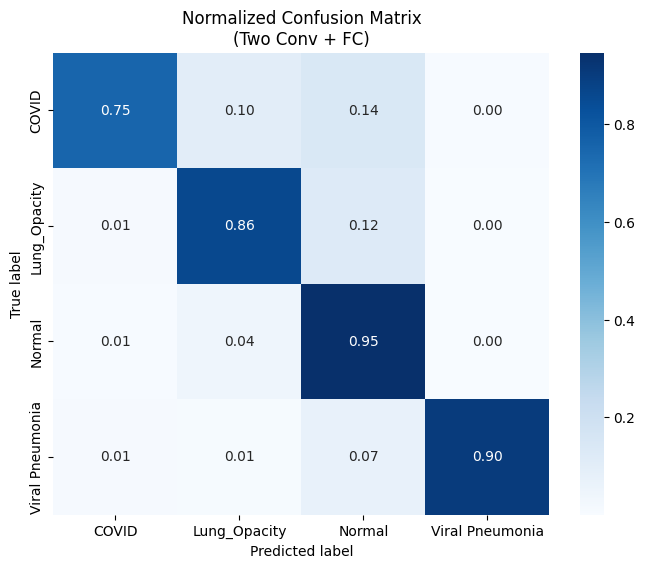


Evaluating configuration: One Conv + FC

Class-wise Sensitivity (Recall):
COVID: 0.8492
Lung_Opacity: 0.8220
Normal: 0.9467
Viral Pneumonia: 0.8501


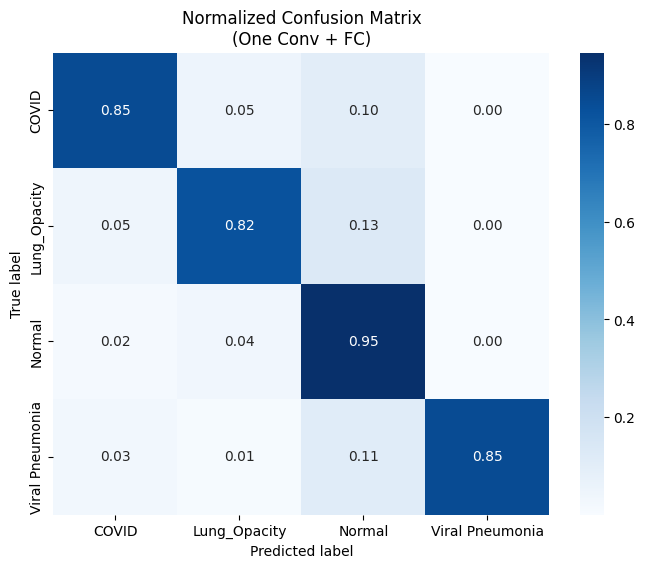


Evaluating configuration: Only FC

Class-wise Sensitivity (Recall):
COVID: 0.8598
Lung_Opacity: 0.8445
Normal: 0.8986
Viral Pneumonia: 0.9318


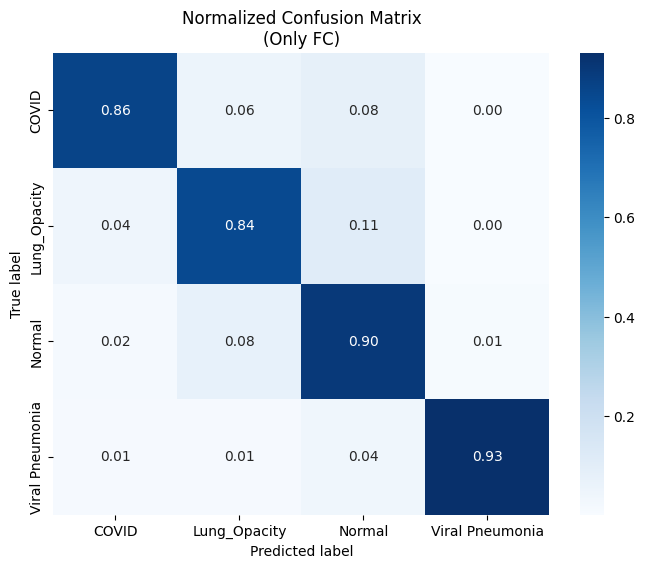


=== Final Results Comparison ===


,Accuracy,Precision,Recall,F1-Score,Sensitivity (Mean),Training Time (s)
One Conv + FC,0.8885,0.8897,0.8885,0.8877,0.8670,2188.1
Two Conv + FC,0.8864,0.8891,0.8864,0.8851,0.8659,2392.9
Only FC,0.8787,0.8788,0.8787,0.8788,0.8837,2164.9



Results saved to /kaggle/working/results_comparison.csv

Training Convergence Curves:


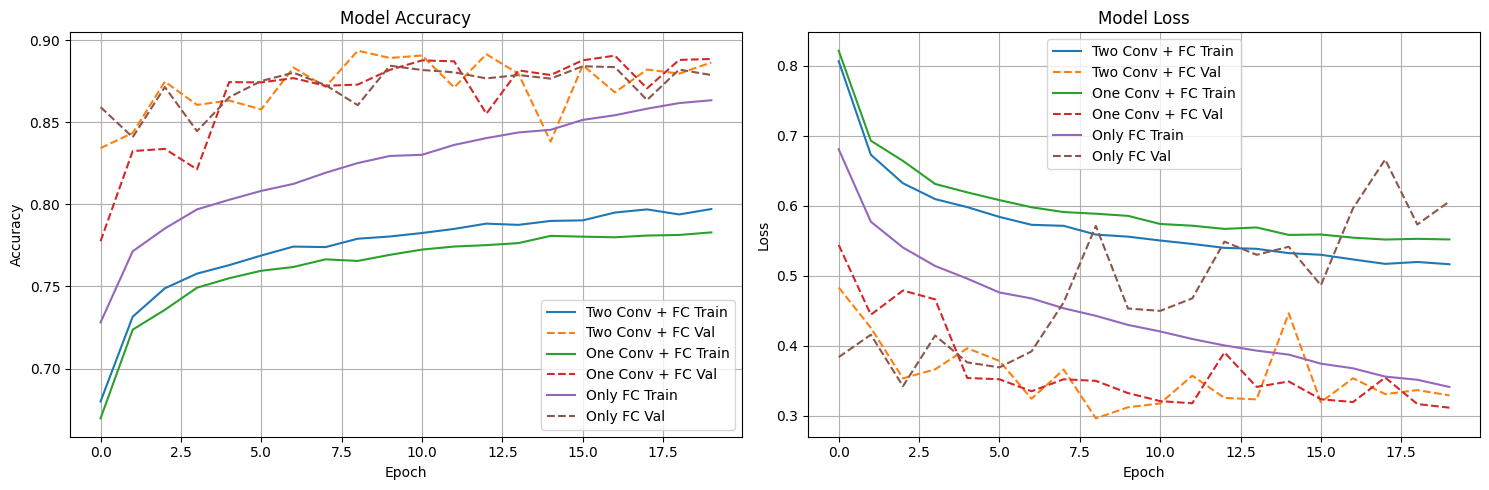

In [53]:
# 9- Presents and compare the obtained results in terms of Accuracy, recall, precision, 
# F1-score, and sensitivity on the validation set, print the convergence curves on both 
# training and validation sets. Presents the training time.  

# -----------------------------------
# 9. Evaluate and Compare Results
# -----------------------------------
print("\n=== Question 9: Evaluate and Compare Results ===")

def compute_metrics(model, generator):
    """Compute classification metrics and confusion matrix"""
    # Get true labels
    y_true = generator.classes
    
    # Predict classes
    y_pred = model.predict(generator, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Classification report
    report = classification_report(y_true, y_pred_classes, 
                                 target_names=list(generator.class_indices.keys()),
                                 output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Sensitivity (recall for each class)
    sensitivity = cm.diagonal() / cm.sum(axis=1)
    
    return report, sensitivity, cm

def plot_convergence(history_dict):
    """Plot training and validation accuracy/loss curves"""
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    for config_name, history in history_dict.items():
        plt.plot(history['accuracy'], label=f"{config_name} Train")
        plt.plot(history['val_accuracy'], '--', label=f"{config_name} Val")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    for config_name, history in history_dict.items():
        plt.plot(history['loss'], label=f"{config_name} Train")
        plt.plot(history['val_loss'], '--', label=f"{config_name} Val")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/convergence_curves.png')
    plt.show()

def plot_confusion_matrix(cm, classes, config_name):
    """Plot normalized confusion matrix"""
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Normalized Confusion Matrix\n({config_name})')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'/kaggle/working/cm_{config_name.replace(" ", "_")}.png')
    plt.show()

# Initialize results dictionary
results = {}

# Evaluate each configuration
for num_conv_layers, config_name in configurations:
    if config_name not in history_dict:
        print(f"Skipping evaluation for {config_name} - no training history")
        continue
        
    print(f"\nEvaluating configuration: {config_name}")
    
    # Load the saved model
    model_path = f"/kaggle/working/model_{config_name.replace(' ', '_')}.h5"
    model = tf.keras.models.load_model(model_path)
    
    # Compute metrics
    report, sensitivity, cm = compute_metrics(model, validation_generator)
    
    # Store results
    results[config_name] = {
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'Sensitivity (Mean)': np.mean(sensitivity),
        'Training Time (s)': training_times[config_name]
    }
    
    # Print class-wise sensitivity
    print("\nClass-wise Sensitivity (Recall):")
    for class_name, sens in zip(validation_generator.class_indices.keys(), sensitivity):
        print(f"{class_name}: {sens:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, list(validation_generator.class_indices.keys()), config_name)

# Create comparison dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Accuracy', ascending=False)

# Format the dataframe for better display
styled_df = results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Sensitivity (Mean)': '{:.4f}',
    'Training Time (s)': '{:.1f}'
}).background_gradient(cmap='Blues', subset=['Accuracy', 'F1-Score'])

print("\n=== Final Results Comparison ===")
display(styled_df)

# Save results to CSV
results_df.to_csv('/kaggle/working/results_comparison.csv')
print("\nResults saved to /kaggle/working/results_comparison.csv")

# Plot convergence curves
print("\nTraining Convergence Curves:")
plot_convergence(history_dict)

In [ ]:











# -----------------------------------
# 10. Report (Guidelines)
# -----------------------------------
print("\n=== Question 10: Report Guidelines ===")
print("""
Report Structure:
1. Introduction: Describe the dataset and transfer learning objective.
2. Methodology: Explain MobileNet, preprocessing, and training configurations.
3. Results: Include table of metrics, convergence curves, and training times.
4. Discussion: Compare configurations (accuracy vs. training time trade-offs).
5. Conclusion: Summarize findings and suggest improvements.

Saved Outputs:
- Results table: /kaggle/working/results.csv
- Convergence curves: /kaggle/working/convergence_curves.png
- Models: /kaggle/working/model_*.h5
""")